### Clustering

In [31]:
# Import Libraries and dependancies 
import pandas as pd
import numpy as np
import hvplot.pandas
import yahoo_fin.stock_info as si
import yfinance as yf
import pyfolio as pf
from scipy.spatial.distance import cdist
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore") 

In [32]:
# 6 big banks
stocks = ['GS', 'C', 'MS', 'JPM', 'BAC', 'WFC']

In [33]:
#pulls 3yrs of date history from today
date_range = '3y' 

end_date = datetime.now()
if date_range == '3y':
    start_date = end_date - timedelta(days=3 * 365)
else:
    raise ValueError("Invalid date range. Use '3y' for 3 years of historical data.")

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

In [34]:
# empty data set, that has a loop to pull historical data for 3yrs, then adds all data to symbol column
data = []

for symbol in stocks:
    ticker = yf.Ticker(symbol)
    historical_data = ticker.history(start=start_date_str, end=end_date_str, interval='1d')[['Open', 'Close', 'High', 'Low', 'Volume']]

    if not historical_data.empty:
        historical_data['Symbol'] = symbol
        data.append(historical_data)
    else:
        print(f'Error data pull for {symbol}')

df = pd.concat(data)

# Filter the DataFrame to include only the 6 stocks
stocks_df = df[df['Symbol'].isin(stocks)]

In [35]:
# Group the stocks by date and then calculate the mean of OHLCV
BIGBportfolio = stocks_df.groupby(stocks_df.index).mean()

In [36]:
# Rename "synthetic" columns
BIGBportfolio.columns = ['Syn_Open', 'Syn_Close', 'Syn_High', 'Syn_Low', 'Sy_Volume']
BIGBportfolio

,Syn_Open,Syn_Close,Syn_High,Syn_Low,Sy_Volume
Date,,,,,
2020-04-07 00:00:00-04:00,61.265570,59.333583,61.895276,58.652256,3.601082e+07
2020-04-08 00:00:00-04:00,60.435955,62.850933,63.258856,59.926762,3.330760e+07
2020-04-09 00:00:00-04:00,64.575197,66.678173,67.973065,64.341217,5.029647e+07
2020-04-13 00:00:00-04:00,66.641232,64.433064,66.858292,64.004479,3.203900e+07
2020-04-14 00:00:00-04:00,65.841082,63.506972,66.286077,61.946370,4.308287e+07
...,...,...,...,...,...
2023-03-31 00:00:00-04:00,108.645060,109.512546,109.687507,108.056113,2.070217e+07
2023-04-03 00:00:00-04:00,109.381402,109.307741,110.391083,108.397048,1.858058e+07
2023-04-04 00:00:00-04:00,109.408969,107.628332,109.518848,106.749644,1.884298e+07


In [37]:
# Calculate the daily return for each stock
# stocks_daily_returns = stocks_df.pivot_table(values='Close', columns='Symbol', index=stocks_df.index).pct_change()
stocks_daily_returns = stocks_df.pivot_table(values='Close', columns='Symbol', index=stocks_df.index).pct_change()

# Calculate the annual return for each stock
annual_returns = stocks_daily_returns.mean() * 252

# Calculate the annual volatility for each stock
annual_volatility = stocks_daily_returns.std() * np.sqrt(252)

In [38]:
BIGBportfolio

,Syn_Open,Syn_Close,Syn_High,Syn_Low,Sy_Volume
Date,,,,,
2020-04-07 00:00:00-04:00,61.265570,59.333583,61.895276,58.652256,3.601082e+07
2020-04-08 00:00:00-04:00,60.435955,62.850933,63.258856,59.926762,3.330760e+07
2020-04-09 00:00:00-04:00,64.575197,66.678173,67.973065,64.341217,5.029647e+07
2020-04-13 00:00:00-04:00,66.641232,64.433064,66.858292,64.004479,3.203900e+07
2020-04-14 00:00:00-04:00,65.841082,63.506972,66.286077,61.946370,4.308287e+07
...,...,...,...,...,...
2023-03-31 00:00:00-04:00,108.645060,109.512546,109.687507,108.056113,2.070217e+07
2023-04-03 00:00:00-04:00,109.381402,109.307741,110.391083,108.397048,1.858058e+07
2023-04-04 00:00:00-04:00,109.408969,107.628332,109.518848,106.749644,1.884298e+07


In [39]:
print("Annual Return:", annual_returns)
print("Annual Volatility:", annual_volatility)

Annual Return: Symbol
BAC    0.157596
C      0.142174
GS     0.291044
JPM    0.190627
MS     0.356443
WFC    0.191674
dtype: float64
Annual Volatility: Symbol
BAC    0.342477
C      0.374210
GS     0.305694
JPM    0.307262
MS     0.321868
WFC    0.389615
dtype: float64


In [40]:
# Prepare a DataFrame for clustering by extracting 'Annual_Return' and 'Annual_Volatility' columns.
data_AR_AV = {'Annual_Return': annual_returns, 'Annual_Volatility': annual_volatility}
X_df = pd.DataFrame(data_AR_AV)
X_df['Ticker'] = stocks

In [41]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.iloc[:, :2])

In [42]:
# Apply PCA for dimensional reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [43]:
# Create an empty list to store the distorded values
distorions = []

In [44]:
# Define a range of k values to test (from 1-5)
# Loop through each k value, fit the model and calculate the distortion
K = range(1,6)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X_pca)
    distorions.append(sum(np.min(cdist(X_pca, kmeans.cluster_centers_, 'euclidean'), axis=1))/X_pca.shape[0])

In [45]:
#plot the elbow curve to visualize the optimal k value
pd.Series(distorions, index=K).hvplot.line(xlabel='k', ylabel='Distortion', title='Elbow Method showing the optimal value for k')

:Curve   [index]   (0)

In [46]:
# Fit the KMeans model
optimal_k= 3
kmeans = KMeans(n_clusters=optimal_k).fit(X_pca)

In [47]:
# assign the cluster labels to each data point
X_df['Cluster'] = kmeans.labels_

In [48]:
# Visualize the clusters by plotting 'Annual_Return' on the z-axis and 'Annual_Volatility' on the y-axis
plot = X_df.hvplot.scatter(x='Annual_Return', y='Annual_Volatility', by='Cluster', hover_cols=['Ticker', 'ETF_Segment'], title='Clusters of ETFs')
plot

:NdOverlay   [Cluster]
   :Scatter   [Annual_Return]   (Annual_Volatility,Ticker)

In [49]:
# # Load data (Replace this with the actual data)
# # Below is example data for demonstration only
# data = {'date': pd.date_range(start='2023-04-01', periods=365, freq='D'), 'close': np.random.rand(365)}
# New_df = pd.DataFrame(data)

In [50]:
# Rename columns to fit Prophet requirements
syn_close_df = BIGBportfolio.reset_index().rename(columns={'index': 'ds', 'Syn_Close': 'y'})

# Create 'ds' column
syn_close_df['ds'] = syn_close_df.index

#Convert 'ds' column to datetime
syn_close_df['ds'] = pd.to_datetime(syn_close_df['ds'])

# Remove timezones from 'ds'
syn_close_df['ds'] = syn_close_df['ds'].dt.tz_localize(None)


In [51]:
# Fit Prophet model
model = Prophet()
model.fit(syn_close_df)

18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Create future dates DataFrame for Predictions 
future = model.make_future_dataframe(periods=365)

In [53]:
# Generate predictions 
forcast = model.predict(future)

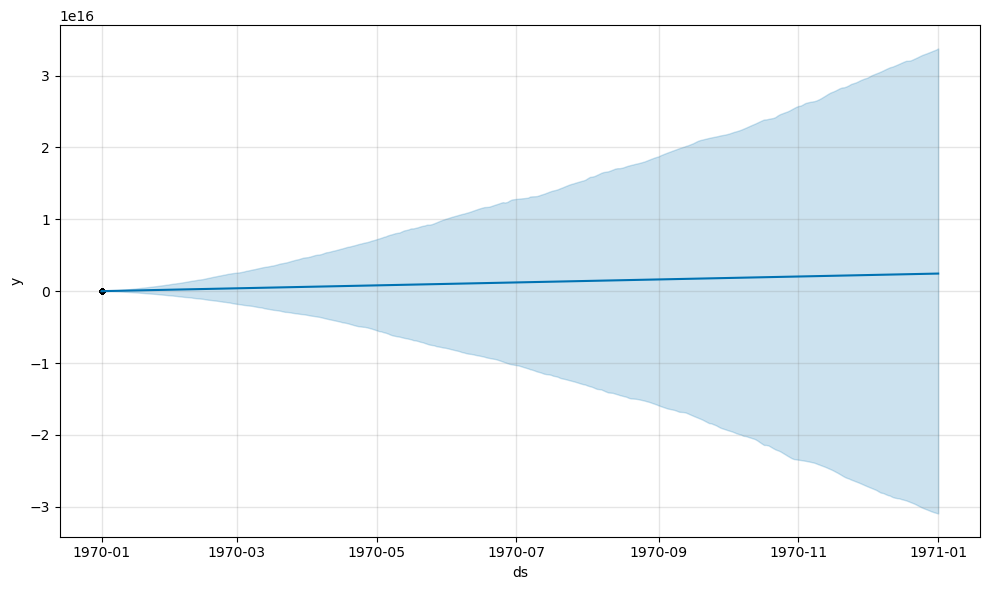

In [54]:
#Plot the forecast
fig = model.plot(forcast)

In [55]:
# Calculate daily returns for the synthetic portfolio
syn_close_df['returns'] = syn_close_df['y'].pct_change()

In [56]:
# Remove first row containing NaN
syn_close_df.dropna(inplace=True)

In [57]:
#convert the index into a datetime type
syn_close_df.index = pd.to_datetime(syn_close_df.index)

In [58]:
# Calculate the daily returns as a series 
returns = syn_close_df['returns']

In [59]:
# create a performance tearsheet
pf.create_full_tear_sheet(returns)

Start date,1970-01-01
End date,1970-01-01
Total months,35
,Backtest
Annual return,22.0%
Cumulative returns,81.4%
Annual volatility,29.9%
Sharpe ratio,0.81
Calmar ratio,0.68
Stability,0.43
Max drawdown,-32.2%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'